In [61]:
import os
import numpy as np
#nibabel allows us to load up the Nifti file type
import nibabel as nib
import matplotlib.pyplot as plt




In [62]:

#import the mgh file from freesurfer with nibabel
#an example you can use is the bert/mri/aparc+aseg.mgz file, which freesurfer provides
segment = nib.load('bert/mri/aparc+aseg.mgz')


In [63]:
# The result is shown as a nibabel object
#as you can see, it must be loaded into a usable array, in numpy format 
print(segment.shape)
segment = segment.get_fdata()
print(segment.shape)


(np.int32(256), np.int32(256), np.int32(256))
(256, 256, 256)


In [64]:
#enter the label of the ROI from the LUT available in freesurfer home directory.
# the ROI I have used are avaiable in the ROI_labels.tsv file. Keep in mind that not all ROI in the LUT contain volumetric data
ROI_labels = [2035]
ROI = np.isin(segment, ROI_labels).astype(np.uint8)
#the result is a 3d array we can now use as a volume 
print(ROI.shape)

(256, 256, 256)


In [65]:

#just making sure the file is not corrupted
print(np.any(segment))
print(np.sum(segment))


True
756520275.0


In [66]:
# counting regular voxels that contain data, to ensure it contains a volume
# this gives us the same number of voxels as size-1 boxes
voxels= np.sum(ROI>0)

if voxels > 0:
    print("File fine")
else:
    print("no volume found ")

File fine


In [67]:
#cropping the ROI
present_voxels = np.argwhere(ROI)
ROI = ROI[
    present_voxels[:, 0].min()-1: present_voxels[:, 0].max() + 1,
    present_voxels[:, 1].min()-1: present_voxels[:, 1].max() + 1,
    present_voxels[:, 2].min()-1: present_voxels[:, 2].max() + 1,
]
print(ROI.shape)


(22, 40, 64)


In [68]:
#expanding the ROI to make it a cube
sx, sy, sz = ROI.shape
maximum = max(sx, sy, sz)
ROI= np.pad(
    ROI,
    pad_width=((0, 240 - sx), (0, 240 - sy), (0, 240 - sz)),
    mode='constant',
    constant_values=0)
padded_shape=240

In [69]:
# finally calculating the FD
# here, we are reshaping the volume, by combining the voxels into box-sized cubes, and checking new voxel occupancy
# this is much faster than counting boxes using a for loop

def box_counting(box_size):
    x, y, z = ROI.shape
    sx= sy= sz = box_size
    reshaped_ROI = ROI.reshape(
        x // sx, sx,
        y // sy, sy,
        z // sz, sz

    ).sum(axis=(1, 3, 5))   #reshape into a new array of box size *box size * box size dimensions
    num_boxes= int((np.sum(reshaped_ROI > 0))) #count the number of new voxels that fill the shape

    return num_boxes

box_counting(1)



7311

In [70]:

y = np.zeros(40)
x=np.zeros(40)
idx = 0
for i in range(padded_shape):
    box_size= i+1
    if padded_shape%box_size==0 and box_size<=maximum:
        box_size=int(box_size)
        num_box= box_counting(box_size)
        y[idx]= num_box
        x[idx]= box_size
        idx += 1
x = x.astype(int)
y = y.astype(int)   
y=y[0:idx]
x=x[0:idx] 

#this returns x, the box length used, and y, the number of boxes which cover the volume
print(x)
print(y)


[ 1  2  3  4  5  6  8 10 12 15 16 20 24 30 40 48 60]
[7311 1449  570  322  203  129   78   44   32   22   19    9    6    5
    2    2    2]


In [71]:
#convert the arrays to a logarithmic scale
log_x= np.log(x)
log_y=np.log(y)
print(log_x)
print(log_y)

[0.         0.69314718 1.09861229 1.38629436 1.60943791 1.79175947
 2.07944154 2.30258509 2.48490665 2.7080502  2.77258872 2.99573227
 3.17805383 3.40119738 3.68887945 3.87120101 4.09434456]
[8.89713534 7.27862894 6.34563636 5.77455155 5.31320598 4.8598124
 4.35670883 3.78418963 3.4657359  3.09104245 2.94443898 2.19722458
 1.79175947 1.60943791 0.69314718 0.69314718 0.69314718]


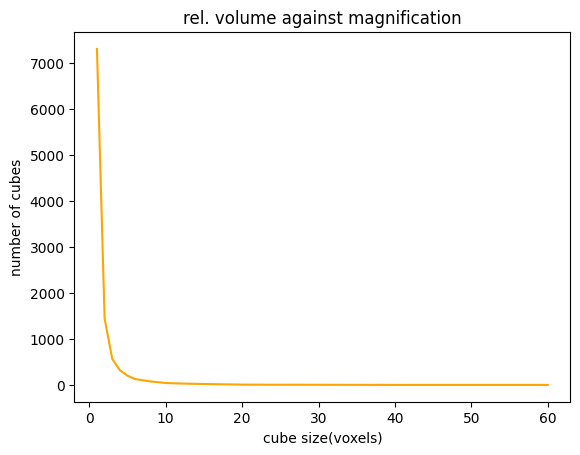

In [72]:
#the cube size against number of cubes

plt.plot(x,y,color='orange')
plt.title('rel. volume against magnification')
plt.xlabel("cube size(voxels)")
plt.ylabel('number of cubes')
plt.show()


In [ ]:
#finding the ideal fractal dimension range, systematically
# selects the widest range of boxes for which the r2 > 0.995 

widest_range = 0 
best_fd = 0
best_r2= 0
stdev_fd= 0
fd_array = np.array([0])
for j in range(1,idx):
    for k in range(1,idx):
        if k>j:
            rf_log_x = log_x[j:k+1]
            rf_log_y = log_y[j:k+1]
            m, c = np.polyfit(rf_log_x, rf_log_y, 1)
            fd = -m
            correlation_coefficient = np.corrcoef(rf_log_x, rf_log_y)[0,1]
            r2 = correlation_coefficient**2
            if 0.995 < r2 < 1: 
                if k-j >= widest_range and k-j>4: 
                    widest_range = k - j
                    min_j = j
                    max_k = k
                    best_fd = fd
                    best_r2 = r2    
                    fd_array = np.append(fd_array, fd)
stdev= np.std(fd_array)



In [74]:
print("the best estimate fractal dimension is: ", best_fd)
print("with R-squared value: ", best_r2, "and standard dev:", stdev)
print( "ideal range is box sizes", x[min_j], "to", x[max_k], "in factors of", padded_shape)
#keep in mind this does not consider multi- or bi-fractals (yet), so in that case the FD with the highest r2 will be chosen

the best estimate fractal dimension is:  2.1227840753193696
with R-squared value:  0.9968079282205515 and standard dev: 0.61042736683692
ideal range is box sizes 2 to 48 in factors of 240


fractal dimension is 2.1929193676109766 and r2 is  0.998926781294561


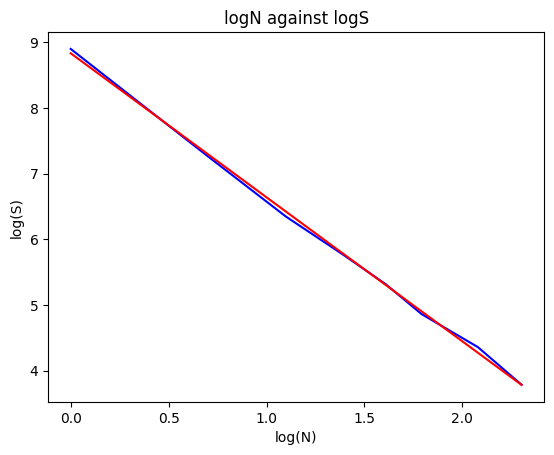

In [ ]:
#use this to explore how the log-log graph changes at different ranges, with a line of best fit!
rf_log_x = log_x[0:8]
rf_log_y = log_y[0:8]
plt.plot(rf_log_x,rf_log_y,color='blue')
plt.title('logN against logS')
plt.xlabel("log(N)")
plt.ylabel('log(S)')
m, c = np.polyfit(rf_log_x, rf_log_y, 1)
best_fit_line = m*rf_log_x + c
plt.plot(rf_log_x, m*rf_log_x + c, color='red') 
fd = -m
correlation_coefficient = np.corrcoef(rf_log_x, rf_log_y)[0, 1]
r2 = correlation_coefficient**2

print("fractal dimension is", fd,"and r2 is ", r2)
